# Stock Price Predictor

## IEEE TEMS Junior Recruitment Task

This notebook demonstrates a time-series approach to predict stock prices using historical data. We'll use both traditional statistical methods (ARIMA) and modern deep learning approaches (LSTM) to create and evaluate our predictions.

### Project Overview
1. Data Collection using yfinance
2. Data Preprocessing and Cleaning
3. Exploratory Data Analysis
4. Feature Engineering
5. Model Development
6. Evaluation and Visualization
7. Future Price Prediction

## 1. Data Collection and Setup

First, let's install and import all the required libraries.

In [1]:
# Install required packages
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow

In [3]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
%matplotlib inline

### Fetch Historical Stock Data
We'll fetch 5 years of historical data for Apple Inc. (AAPL) using yfinance.

In [4]:
# Define the stock symbol and time period
symbol = 'AAPL'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # 5 years of data

# Fetch the data
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Display the first few rows and basic information
print("Dataset Shape:", stock_data.shape)
print("\nFirst few rows of the data:")
stock_data.head()

/tmp/ipython-input-1151034027.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Dataset Shape: (1253, 5)

First few rows of the data:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-09-03,117.582123,125.324955,117.212493,123.447617,257599600
2020-09-04,117.659927,120.325172,107.864661,116.794209,332607200
2020-09-08,109.742004,115.743670,109.605825,110.841173,231366600
2020-09-09,114.119247,115.889593,112.115451,114.060887,176940500
2020-09-10,110.393723,117.212475,109.430734,117.076295,182274400


## 2. Exploratory Data Analysis

Let's analyze the data to understand the patterns and trends.

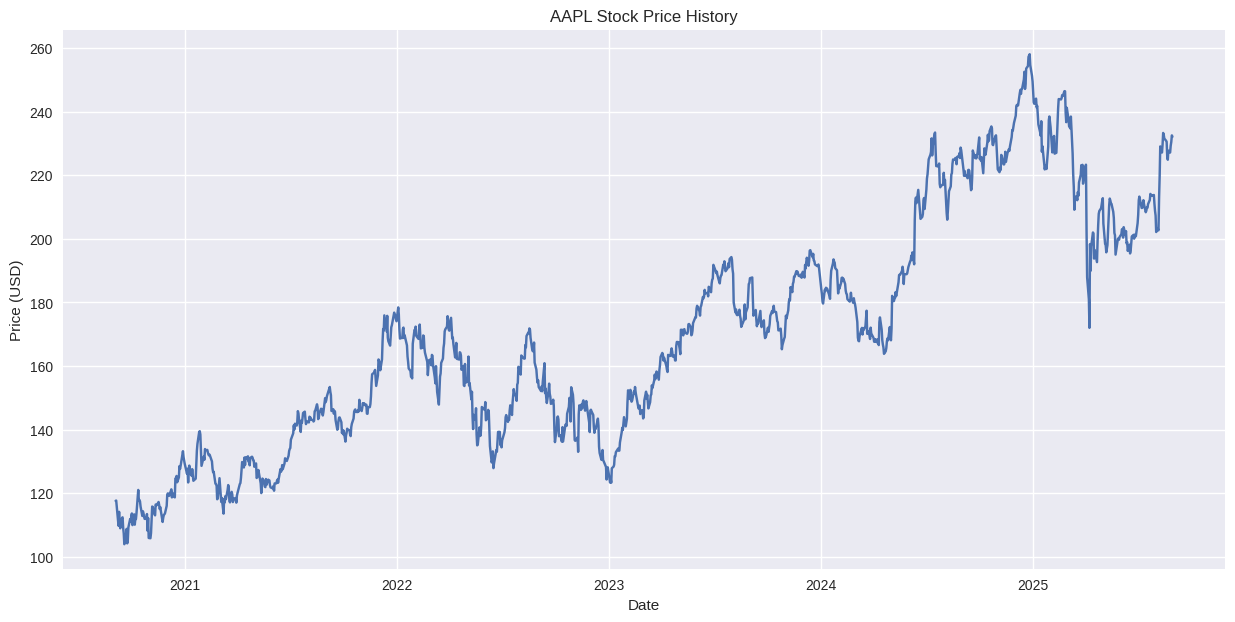


Basic Statistics:
Ticker         AAPL
count   1253.000000
mean     169.871576
std       36.270925
min      103.925163
25%      142.247208
50%      167.636169
75%      193.355270
max      258.103729


In [5]:
# Plot the closing price history
plt.figure(figsize=(15, 7))
plt.plot(stock_data.index, stock_data['Close'])
plt.title(f'{symbol} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()

# Calculate and display basic statistics
print("\nBasic Statistics:")
print(stock_data['Close'].describe())

## 3. Feature Engineering

Create technical indicators that might help in prediction:

In [16]:
def add_technical_indicators(df):
    # Ensure 'Close' column is accessible, handling potential MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        close_price = df['Close'].iloc[:, 0] # Access the first column of the 'Close' level
    else:
        close_price = df['Close']

    # Create a new DataFrame to store indicators, including 'Close' and 'Volume'
    df_indicators = pd.DataFrame(index=df.index)
    df_indicators['Close'] = close_price
    # Add the Volume column, handling potential MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        df_indicators['Volume'] = df['Volume'].iloc[:, 0]
    else:
        df_indicators['Volume'] = df['Volume']


    # Moving averages
    df_indicators['MA20'] = df_indicators['Close'].rolling(window=20).mean()
    df_indicators['MA50'] = df_indicators['Close'].rolling(window=50).mean()

    # Relative Strength Index (RSI)
    delta = df_indicators['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df_indicators['RSI'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    df_indicators['BB_middle'] = df_indicators['Close'].rolling(window=20).mean()
    rolling_std = df_indicators['Close'].rolling(window=20).std()
    df_indicators['BB_upper'] = df_indicators['BB_middle'] + 2 * rolling_std
    df_indicators['BB_lower'] = df_indicators['BB_middle'] - 2 * rolling_std


    return df_indicators

# Add technical indicators
stock_data_processed = add_technical_indicators(stock_data)

# Drop any rows with NaN values
stock_data_processed = stock_data_processed.dropna()

# Display the first few rows with new features
stock_data_processed.head()

,Close,Volume,MA20,MA50,RSI,BB_middle,BB_upper,BB_lower
Date,,,,,,,,
2020-11-12,116.157730,103162300,112.401789,111.999256,56.331164,112.401789,118.906220,105.897358
2020-11-13,116.206459,81581900,112.423469,111.971743,56.381764,112.423469,118.977908,105.869030
2020-11-16,117.219841,91183000,112.643671,111.962941,55.731495,112.643671,119.540576,105.746766
2020-11-17,116.333138,74271000,112.745124,112.094764,64.182414,112.745124,119.802693,105.687556
2020-11-18,115.007957,76322100,112.811445,112.112538,55.427318,112.811445,119.930724,105.692167


## 4. Model Development

We'll implement an LSTM model for prediction. First, let's prepare our data:

In [17]:
def prepare_data(data, look_back=60):
    # Select features for prediction
    features = ['Close', 'Volume', 'MA20', 'MA50', 'RSI', 'BB_upper', 'BB_lower']
    dataset = data[features].values

    # Scale the data
    scaler = MinMaxScaler()
    dataset = scaler.fit_transform(dataset)

    # Create sequences for LSTM
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(dataset[i + look_back, 0])  # predict close price

    return np.array(X), np.array(y), scaler

# Prepare data for modeling
look_back = 60  # Use 60 days of history to predict the next day
X, y, scaler = prepare_data(stock_data_processed, look_back)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (915, 60, 7)
Testing set shape: (229, 60, 7)


In [18]:
# Build LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(look_back, 7), return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=0.1,
                   verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,851 (124.42 KB)

 Trainable params: 31,851 (124.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - loss: 0.0810 - val_loss: 0.0551
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0067 - val_loss: 0.0183
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0050 - val_loss: 0.0109
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0047 - val_loss: 0.0074
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0041 - val_loss: 0.0069
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0037 - val_loss: 0.0054
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0034 - val_loss: 0.0064
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0033 - val_loss: 0.0053
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0032 - val_loss: 0.0070
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0029 - val_loss: 0.0079
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0032 - val_loss: 0.0077
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.

## 5. Model Evaluation

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Train RMSE: 0.04
Test RMSE: 0.08


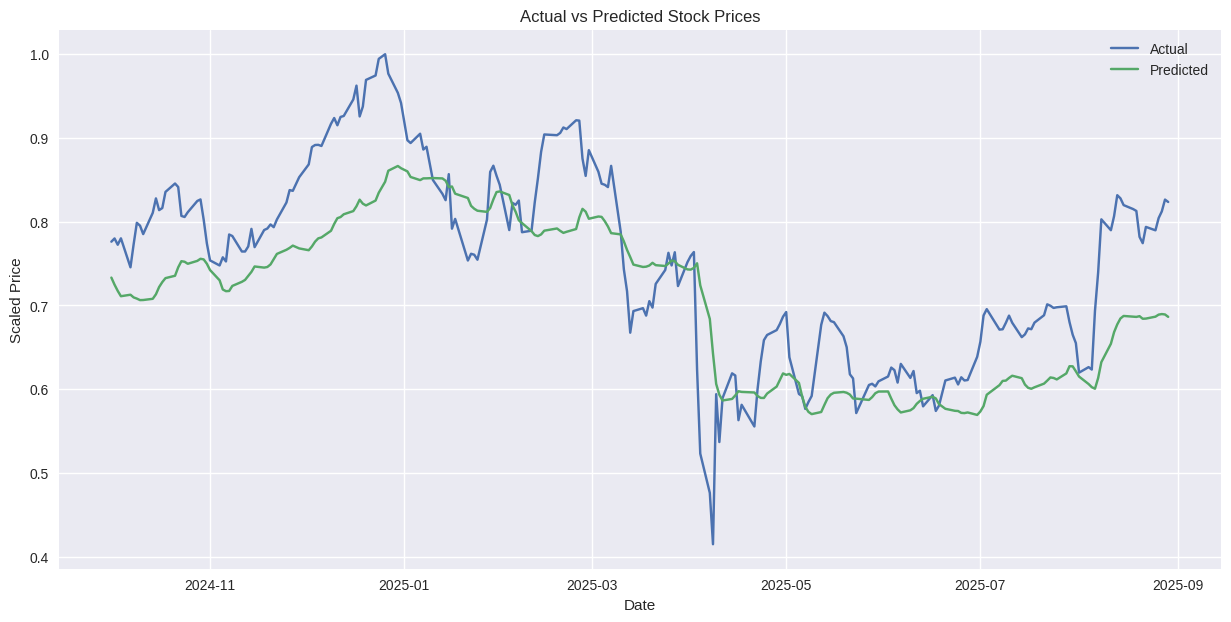

In [19]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Plot actual vs predicted prices
plt.figure(figsize=(15, 7))
plt.plot(stock_data.index[-len(y_test):], y_test, label='Actual')
plt.plot(stock_data.index[-len(y_test):], test_predict, label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.legend()
plt.grid(True)
plt.show()

## 6. Future Price Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted closing price for next trading day: $211.95


/tmp/ipython-input-3991166931.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction_array[0, 0] = next_day_prediction[0]


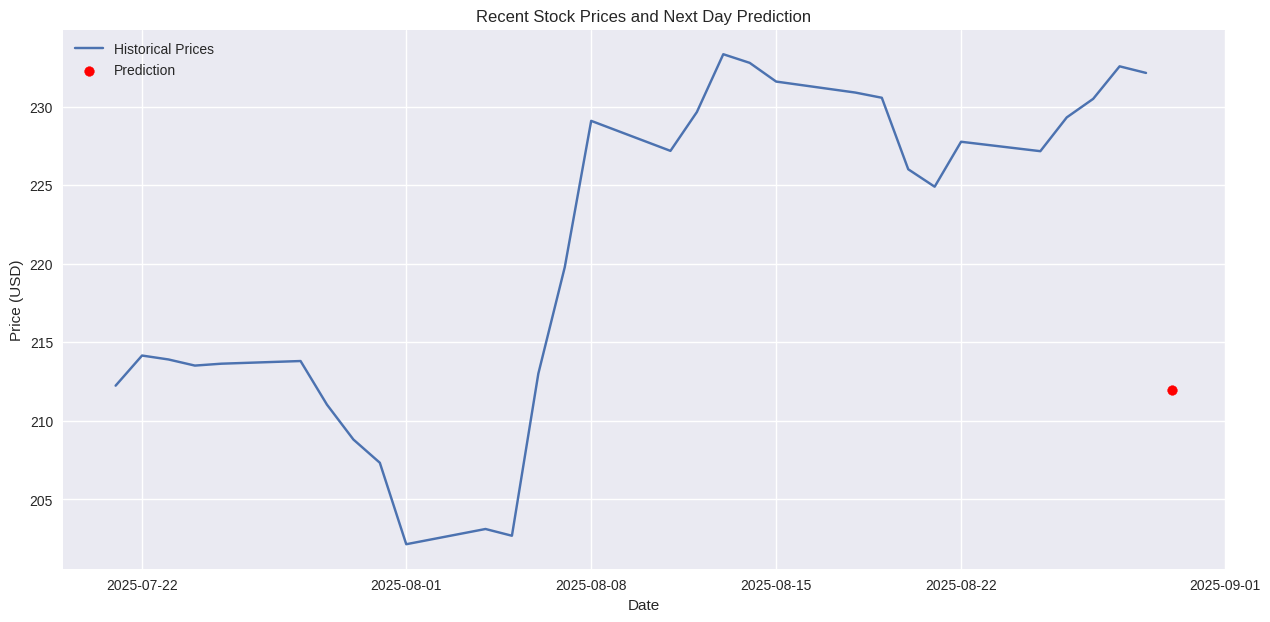

In [20]:
# Prepare the most recent data for prediction
last_sequence = X[-1:]

# Make prediction for the next day
next_day_prediction = model.predict(last_sequence)

# Inverse transform the prediction
prediction_array = np.zeros((1, 7))
prediction_array[0, 0] = next_day_prediction[0]
next_day_price = scaler.inverse_transform(prediction_array)[0, 0]

print(f"Predicted closing price for next trading day: ${next_day_price:.2f}")

# Plot recent prices and prediction
plt.figure(figsize=(15, 7))
plt.plot(stock_data.index[-30:], stock_data['Close'][-30:], label='Historical Prices')
plt.scatter(stock_data.index[-1] + timedelta(days=1), next_day_price, color='red', label='Prediction')
plt.title('Recent Stock Prices and Next Day Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()